In [1]:
!pip install tensorflow matplotlib


In [2]:
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [5]:
!git clone https://github.com/tensorflow/examples.git


Cloning into 'examples'...
remote: Enumerating objects: 24235, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 24235 (delta 6), reused 5 (delta 3), pack-reused 24215 (from 2)
Receiving objects: 100% (24235/24235), 44.22 MiB | 36.73 MiB/s, done.
Resolving deltas: 100% (13168/13168), done.


In [6]:
import sys
sys.path.append('/content/examples')


In [7]:
from tensorflow_examples.models.pix2pix import pix2pix


In [9]:
!git clone https://github.com/tensorflow/examples.git


fatal: destination path 'examples' already exists and is not an empty directory.


In [10]:
import sys
sys.path.append('/content/examples')


In [11]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt


In [12]:
dataset, info = tfds.load('cycle_gan/horse2zebra', with_info=True, as_supervised=True)
train_horses, test_horses = dataset['trainA'], dataset['testA']
train_zebras, test_zebras = dataset['trainB'], dataset['testB']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.JF0VU7_3.0.0/cycle_gan-trainA.tfrecord*..…

Generating trainB examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.JF0VU7_3.0.0/cycle_gan-trainB.tfrecord*..…

Generating testA examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.JF0VU7_3.0.0/cycle_gan-testA.tfrecord*...…

Generating testB examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.JF0VU7_3.0.0/cycle_gan-testB.tfrecord*...…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0. Subsequent calls will reuse this data.


In [13]:
def preprocess_image_train(image, label):
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

train_horses = train_horses.map(preprocess_image_train).cache().shuffle(1000).batch(1)
train_zebras = train_zebras.map(preprocess_image_train).cache().shuffle(1000).batch(1)


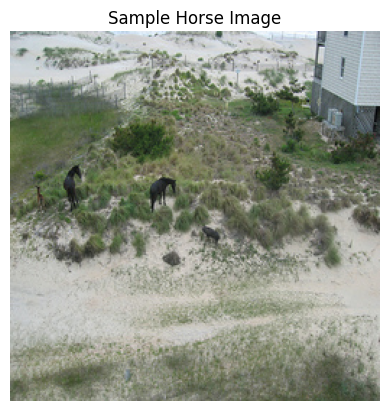

In [14]:
for image in train_horses.take(1):
    plt.imshow((image[0] + 1) / 2)
    plt.axis('off')
    plt.title("Sample Horse Image")
    plt.show()


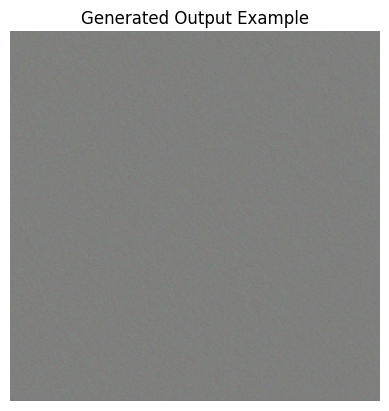

In [15]:
OUTPUT_CHANNELS = 3  # For RGB image

generator = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='batchnorm')
generator_output = generator(tf.random.normal([1, 256, 256, 3]))
plt.imshow((generator_output[0] + 1) / 2)
plt.title("Generated Output Example")
plt.axis('off')
plt.show()


In [16]:
discriminator = pix2pix.discriminator(norm_type='batchnorm', target=True)
disc_output = discriminator([tf.random.normal([1, 256, 256, 3]), tf.random.normal([1, 256, 256, 3])])
print("Discriminator output shape:", disc_output.shape)


Discriminator output shape: (1, 30, 30, 1)


In [17]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [18]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [19]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


In [20]:
import matplotlib.pyplot as plt

def generate_images(model, input_image, target):
    prediction = model(input_image, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [input_image[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')
    plt.show()


In [21]:
import time

def fit(train_ds, epochs):
    for epoch in range(epochs):
        start = time.time()

        print(f"\nEpoch {epoch+1}/{epochs}")
        for input_image, target in train_ds:
            train_step(input_image, target)

        # Generate example output
        for example_input, example_target in test_dataset.take(1):
            generate_images(generator, example_input, example_target)

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f"Time taken for epoch {epoch+1} is {time.time()-start:.2f} sec")


In [26]:
!ls facades/train/


ls: cannot access 'facades/train/': No such file or directory


In [27]:
# Step 1: Download the dataset
!curl -O http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.7M  100 28.7M    0     0  3994k      0  0:00:07  0:00:07 --:--:-- 3737k


In [28]:
# Step 2: Unzip the dataset
!tar -xf facades.tar.gz


In [29]:
train_images = tf.data.Dataset.list_files('facades/train/*.jpg', shuffle=True)
train_dataset = train_images.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(400).batch(1)


In [33]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    real_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image


In [36]:
def resize(input_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image


In [37]:
def normalize(input_image):
    input_image = (input_image / 127.5) - 1
    return input_image


In [38]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image = resize(input_image, 256, 256)
    real_image = resize(real_image, 256, 256)
    input_image = normalize(input_image)
    real_image = normalize(real_image)
    return input_image, real_image


In [39]:
test_images = tf.data.Dataset.list_files('facades/test/*.jpg', shuffle=False)
test_dataset = test_images.map(load_image_test)
test_dataset = test_dataset.batch(1)


In [40]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 3)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.ke


In [41]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)    # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)      # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)      # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()


In [42]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator Loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

# Generator Loss
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss


In [43]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [44]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


In [45]:
def fit(train_ds, epochs):
    for epoch in range(epochs):
        print("Epoch", epoch+1)
        for input_image, target in train_ds:
            train_step(input_image, target, epoch)


In [46]:
EPOCHS = 20  # You can increase for better results

fit(train_dataset, EPOCHS)


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20


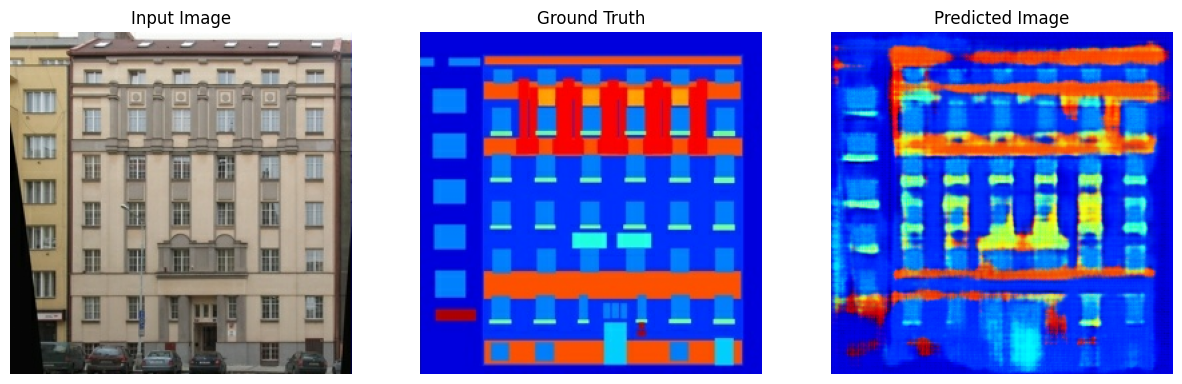

In [47]:
import matplotlib.pyplot as plt

def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Scaling images back from [-1, 1] to [0, 1]
        plt.imshow((display_list[i] + 1) / 2.0)
        plt.axis('off')
    plt.show()

# Generate results on first test image
for inp, tar in test_dataset.take(1):
    generate_images(generator, inp, tar)
